Attributes of satellite images are transferred to the map image
Retain the properties as it is

Paired 2 Paired correspondence

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://github.com/mrzhu-cool/pix2pix-pytorch/blob/master/train.py

https://towardsdatascience.com/cyclegans-and-pix2pix-5e6a5f0159c4

# **Download the Map dataset from the given link**

In [ ]:
import urllib3 as urllib
import os
#if already uploaded read from here

if not os.path.exists("maps"):
    import urllib.request as request
    url = "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz"
    request.urlretrieve(url,"pix2pix.gz")

import tarfile
if not os.path.exists("maps"):
    with tarfile.open("pix2pix.gz","r") as f:
        f.extractall()
! ls

maps  pix2pix.gz  sample_data


# **Imports**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim  as optim
import matplotlib.pyplot as plt
import time
from math import log10
import gc
from google.colab import drive
from torchvision.utils import save_image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


drive.mount("content/")

Mounted at content/


Folder structure

maps->train->subfolder

maps->val->test


In [ ]:
! mkdir /content/maps/train/subfolder 
! mv /content/maps/train/*.jpg /content/maps/train/subfolder


print("#Training images:")
! ls /content/maps/train/subfolder | wc -l


! mkdir /content/maps/val/test 
! mv /content/maps/val/*.jpg /content/maps/val/test

print("#Validation images:")
! ls /content/maps/val/test | wc -l

#Training images:
1096
#Validation images:
1098


# **Hyperparameters**

In [ ]:
learning_rate = 0.0002
batch_size = 8
img_size = 256
in_channel = 3
out_channel = 3
dis_feature = 64
gen_feature = 64
n_epochs = 50


# latent_dim = 50
# num_classes = 10
# embed_size = 50

# **Iterable Loader**

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*in_channel,[0.5]*in_channel),
])

train_data = ImageFolder(root="/content/maps/train/", transform=transformations,)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
val_data = ImageFolder(root="/content/maps/val/", transform=transformations)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=1)


test_files = []
for val_files,_ in val_data.samples:
    #val_data.sample return the file path for each image
    #for the maps dataset, the file names are numeric, 
    #/content/maps/train/subfolder/871.jpg, I am storing 871 in the test files
    
    num = val_files.split("/")[-1].split(".")[0]
    test_files.append(num)

Plotting training data

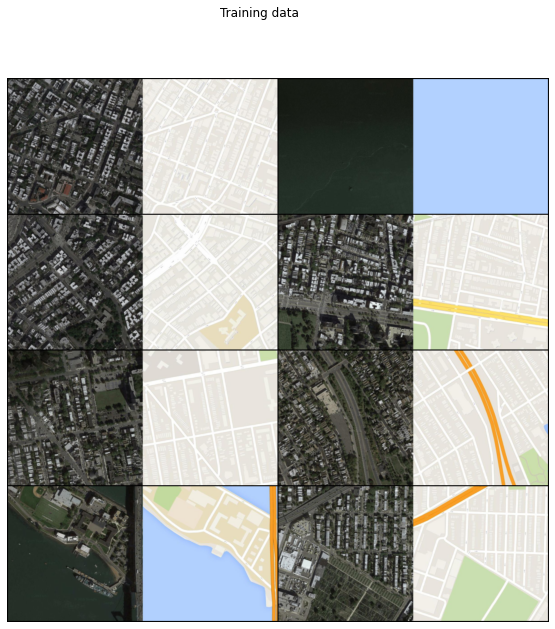

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Training data")
for img,_ in train_data_loader:
    grid = torchvision.utils.make_grid((img*0.5 + 0.5),nrow=2)
    plt.imshow(grid.permute(1,2,0))
    break
plt.axis("off")
plt.show()

Plotting validation data

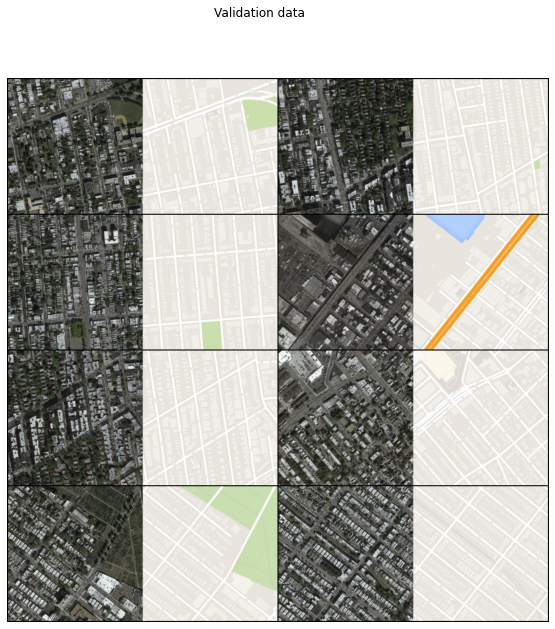

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Validation data")
for pair,_ in val_data_loader:
    grid = torchvision.utils.make_grid((pair*0.5 + 0.5),nrow=2)
    plt.imshow(grid.permute(1,2,0))
    break
plt.axis("off")
plt.show()

In [ ]:
#@title
# x = img[0][:,:,:img_size]
# y = img[0][:,:,img_size:]
# plt.imshow((x*0.5+0.5).permute(1,2,0))
# plt.show()
# plt.imshow((y*0.5+0.5).permute(1,2,0))
# plt.show()

To perform image to image translation, I am using the Conditional GAN

# **Discriminator network**

|                         |
-----------------------------
| Convolutional 2D network|
| Leaky Relu              |
-----------------------------
| Convolutional 2D network|
| Batch Normalization     |
| Leaky Relu              |
-----------------------------
| Convolutional 2D network|
| Batch Normalization     |
| Leaky Relu              |
-----------------------------
| Convolutional 2D network|
| Batch Normalization     |
| Leaky Relu              |
-----------------------------
| Convolutional 2D network|
| Sigmoid                 |
-----------------------------

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self,in_channel,dis_feature):
        super(ConditionalDiscriminator,self).__init__()

        #no batch normalization in the first layer of discriminator
    
        #Size of the input is Batch * channel * W * H
        self.disc_network = nn.Sequential(
                            nn.Sequential(
                                    nn.Conv2d(in_channel,dis_feature,kernel_size=4,padding=1,stride=2),  #32
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature,dis_feature*2,kernel_size=4,padding=1,stride=2,bias=False), #16
                                    nn.BatchNorm2d(dis_feature*2),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature*2,dis_feature*4,kernel_size=4,padding=1,stride=2,bias=False),#8
                                    nn.BatchNorm2d(dis_feature*4),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature*4,dis_feature*8,kernel_size=4,padding=1,stride=2,bias=False),#4
                                    nn.BatchNorm2d(dis_feature*8),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Conv2d(dis_feature*8,1,kernel_size=4,padding=0,stride=2), #1*1,
                            nn.Sigmoid(),   #slope the output should lie between 0 and 1
                        )
        
    def forward(self,x):
        out = self.disc_network(x)
        return out


# **Generator network**

|                         |
---------------------------------
| ReflectionPad2D         |
| Convolutional 2D network|
| Batch Normalization     |
| Relu                    |
---------------------------------
| Convolutional 2D network|
| Batch Normalization     |
| Relu                    |
---------------------------------
|     Resnet Block        |
---------------------------------
| Conv Transpose2D network|
| Batch Normalization     |
| Relu                    |
---------------------------------
| ReflectionPad2d         |
| Convolutional 2D network|
| Tanh                    |
---------------------------------



# **RESNET BLOCK**
|                         |
---------------------------
| ReflectionPad2d         |
---------------------------
| Convolutional 2D network|
---------------------------
| Batch Normalization     |
---------------------------
| Relu                    |
---------------------------
| Dropout                 |
---------------------------
| ReflectionPad2d         |
---------------------------
| Convolutional 2D network|
---------------------------
| Batch Normalization     |
-----------------------------

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self,input_dim,output_dim,gen_feature):
        super(ConditionalGenerator,self).__init__()
        self.inconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_dim, gen_feature, kernel_size=7, padding=0,bias=False),
            nn.BatchNorm2d(gen_feature),
            nn.ReLU()
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(gen_feature,gen_feature*2, kernel_size=3,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_feature*2),
            nn.ReLU()
        )

        self.down2 = nn.Sequential(
            nn.Conv2d(gen_feature*2,gen_feature*4, kernel_size=3,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_feature*4),
            nn.ReLU()
        )

        bottleneck = []
        for i in range(8):
            bottleneck+=[

                nn.Sequential(nn.ReflectionPad2d(1),
                                nn.Conv2d(gen_feature*4, gen_feature*4, kernel_size=3, padding=0, bias=False),
                                nn.BatchNorm2d(gen_feature*4),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.ReflectionPad2d(1),
                                nn.Conv2d(gen_feature*4, gen_feature*4, kernel_size=3, padding=0, bias=False),
                                nn.BatchNorm2d(gen_feature*4),
                            )
            ]
        self.resnet_connections = nn.Sequential(*bottleneck)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(gen_feature*4, gen_feature*2,stride=2,kernel_size=3,  padding=1,bias=False, output_padding=1),
            nn.BatchNorm2d(gen_feature*2),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(gen_feature*2, gen_feature,stride=2,kernel_size=3,  padding=1,bias=False, output_padding=1),
            nn.BatchNorm2d(gen_feature),
            nn.ReLU()
        )
        self.outconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(gen_feature, output_dim, kernel_size=7, padding=0),
            nn.Tanh()
        )
    def forward(self,x):

        out = self.inconv(x)
        out = self.down1(out)
        out = self.down2(out)
        out = nn.ReLU()(out + self.resnet_connections(out))
        out = self.up1(out)
        out = self.up2(out)
        out = self.outconv(out)
        return out     


# **INITIALZE THE WEIGHTS OF CONV,CONV2D and BatchNorm layers of the  NETWORK USING NORMAL DISTIBUTION**

In [ ]:
def initialize_model_weights(nn_model):
    for layer in nn_model.modules():
        if isinstance(layer,(nn.ConvTranspose2d,nn.Conv2d,nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data,0.0,0.02) #paper has zero centerd normal distribution


In [ ]:
torch.autograd.set_detect_anomaly(True)

**INSTANTIATE**
1. **GENERATOR**
2. **DISCRIMINATOR**

**INITIALIZE WEIGHTS**

**ADAM OPTIMIZER**
1. **GENERATOR**
2. **DISCRIMINATOR**

**OBJECTIVE FUNCTION**

BCE loss

L1 loss

MSE loss

In [ ]:
cgen_model = ConditionalGenerator(in_channel,out_channel,gen_feature).to(device)
cdis_model = ConditionalDiscriminator(in_channel+out_channel,dis_feature).to(device)


initialize_model_weights(cgen_model)
initialize_model_weights(cdis_model)


cgen_optimizer = optim.Adam(cgen_model.parameters(),lr=learning_rate, betas=(0.5,0.9)) #authors of the paper use 0.5 for beta1
cdis_optimizer = optim.Adam(cdis_model.parameters(),lr=learning_rate, betas=(0.5,0.9))


cgan_criterion = nn.BCELoss().to(device)

l1_criterion = nn.L1Loss().to(device)
mse_criterion = nn.MSELoss().to(device)

In [ ]:
gc.collect()

2274

The goal is that the generator learns to produce the google maps


The idea is to take the satellite image(instead of a noise) and give it to the generator. The generator gives out the image let's call this fake map.


The discriminator will get the pair (satellite image, fake map), find the loss let's call this the fake loss
The discriminator will get the pair (satellite image, real map) find the loss let's call this the real loss

the total discriminator loss = (real loss + fake loss)/2
Propagate this loss backwards

-------------------

Train the generator: Send the (satellite image,fake map) to the discriminator, calculate the loss with respect to it
Find the loss with respect to the fake map and the real map
The total loss of the generator is the loss wrt discriminator + l1(fake map,real map)





# **Discriminator objective:**
**Maximize**:   E[log(D(real map,satellite)) + E[log(1 - D(fake map, G(satellite)))]
# **Generator objective:**
**Minimize**: E[log(D(fake map, G(satellite)))]


In [ ]:
step=0
lambda_ = 10

ctraining_history = {}
ctraining_history['D_losses'] = []
ctraining_history['G_losses'] = []
ctraining_history['per_epoch_times'] = []
ctraining_history['total_time'] = []


cgen_model.train()
cdis_model.train()
start = time.time()
for epoch in range(n_epochs):
    dis_losses = []
    gen_losses = []
    start_time = time.time()


    for batch_id, (paired_img,_) in enumerate(train_data_loader):

        #the pair image has satellite in [0:img_size] and the google map is in [img_size:]
        satellite = paired_img[:,:,:,:img_size].to(device)
        real_map = paired_img[:,:,:,img_size:].to(device)
        gc.collect()

        #get the fakemap
        fake_map = cgen_model(satellite)
        

        #train discriminator first
        #maximize the score(real)+score(1-fake)
        #concatenate the satellite and real map, feed it to the dicriminator model, i am calling this cdis=>concatenated

        dis_real_out = cdis_model(torch.cat([satellite,real_map],1)).reshape(-1) #only one value across all the batch for every example
        dis_real_loss = cgan_criterion(dis_real_out,torch.ones_like(dis_real_out))  #bce loss
        
        #concatenate the satellite and fake map from generator, feed it to the dicriminator model, i am calling this cdis=>concatenated
        dis_fake_out = cdis_model(torch.cat([satellite,fake_map],1)).reshape(-1) #only one value across all the batch for every example
        dis_fake_loss = cgan_criterion(dis_fake_out,torch.zeros_like(dis_fake_out)) #bce loss

        dis_loss = (dis_real_loss + dis_fake_loss)/2  #total loss of the discriminator
        cdis_model.zero_grad()
        dis_loss.backward(retain_graph=True) #we need to use the fake again retain the graph
        #backpropagate
        
        cdis_optimizer.step()
        #train generator   #maximize score(fake wrt d)
        gen_output = cdis_model(torch.cat([satellite,fake_map],1)).reshape(-1)
        gen_loss = cgan_criterion(gen_output,torch.ones_like(gen_output))

        #loss between the real and fake map times a regularization constant lambda_
        l1_loss = l1_criterion(fake_map, real_map) * lambda_
        total_gen_loss = gen_loss + l1_loss
        

        cgen_model.zero_grad()
        total_gen_loss.backward() #backpropagate

        cgen_optimizer.step()
        
        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

        if batch_id %100 == 0:
            print(f"Epoch {epoch}/{n_epochs} Batch: {batch_id}/{len(train_data_loader)}\
                    Disciminator Loss {dis_loss}\
                    Generator Loss {gen_loss}")
        
    #Validation needs only testing the generator
    #check the loss between the fake map generated by the generator and real map
    with torch.no_grad():

        avg_perception_loss = 0
        # test_noise = torch.randn(label.size(0),latent_dim,1,1).to(device)
        for test_pair,_ in val_data_loader:
            #for the test pair satellite image is [0:img_size]
            test_satellite = test_pair.to(device)[:,:,:,:img_size]
            #real map is [img_size: ]
            real_map = test_pair.to(device)[:,:,:,img_size:]

            #get the output from the trained generator model
            fake_map = cgen_model(test_satellite)
            #find the mean square error between the real map and the one generated by the generator
            mse = mse_criterion(fake_map, real_map)
            #the perception loss
            perception_loss = 10 * log10(1 / mse.item())
            avg_perception_loss += perception_loss            
        print("Average loss on test data:",avg_perception_loss/len(val_data_loader))
    end_time = time.time()
    per_epoch_time = end_time - start_time
    
    #add it to the history
    ctraining_history['D_losses'].append(torch.mean(torch.FloatTensor(dis_losses)))
    ctraining_history['G_losses'].append(torch.mean(torch.FloatTensor(gen_losses)))
    ctraining_history['per_epoch_times'].append(per_epoch_time)

end = time.time()
total_time = end - start
ctraining_history['total_time'].append(total_time)


Epoch 0/50 Batch: 0/137                    Disciminator Loss 0.6941004991531372                    Generator Loss 0.7047841548919678
Epoch 0/50 Batch: 100/137                    Disciminator Loss 0.13868185877799988                    Generator Loss 2.136936902999878
Average loss on test data: 16.418492869511432
Epoch 1/50 Batch: 0/137                    Disciminator Loss 0.08402958512306213                    Generator Loss 2.6590652465820312
Epoch 1/50 Batch: 100/137                    Disciminator Loss 0.16917124390602112                    Generator Loss 2.4235455989837646
Average loss on test data: 14.096299291852606
Epoch 2/50 Batch: 0/137                    Disciminator Loss 0.17966248095035553                    Generator Loss 2.5922739505767822
Epoch 2/50 Batch: 100/137                    Disciminator Loss 1.3646583557128906                    Generator Loss 0.6945986151695251
Average loss on test data: 14.480612279175137
Epoch 3/50 Batch: 0/137                    Disciminator

# **TESTING ON THE TEST DATASET**

creating a new folder to store the generated maps for the test data

In [ ]:
!mkdir /content/myresults

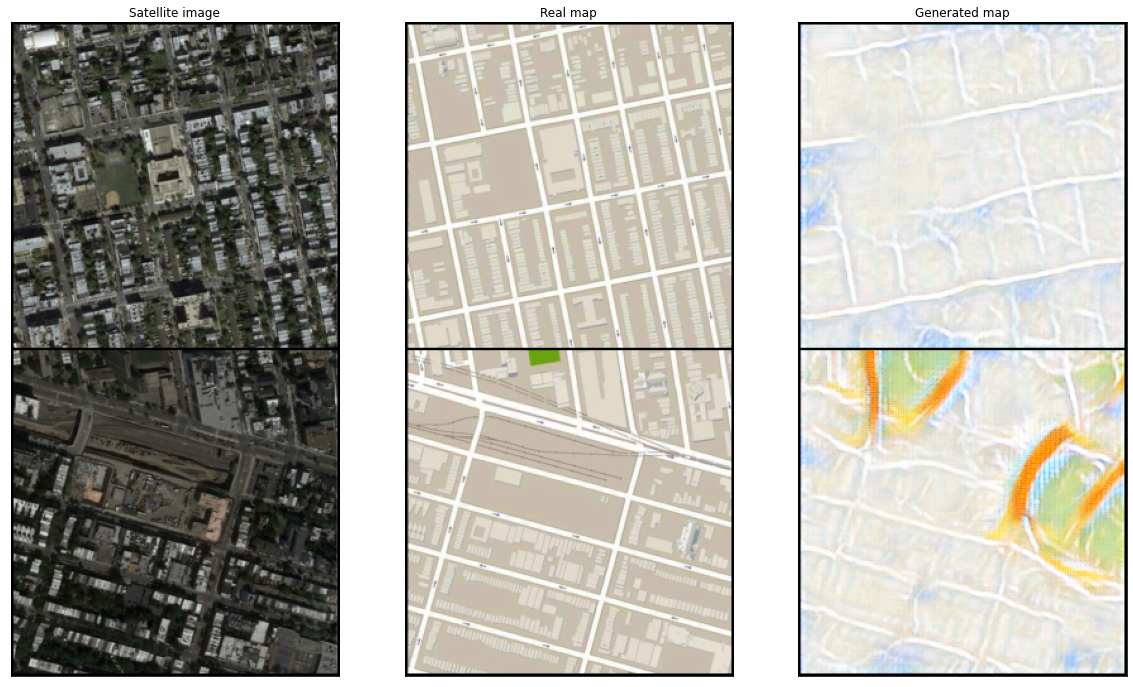

In [ ]:
with torch.no_grad():
    i =0
    for test_pair,_ in val_data_loader:
        test_satellite = test_pair.to(device)[:,:,:,:img_size]
        real_map = test_pair.to(device)[:,:,:,img_size:]
        fake_map = cgen_model(test_satellite)
        for k in range(fake_map.size(0)):
            save_image(fake_map[k],"/content/myresults/"+test_files[i+k]+".jpg")
        i+=fake_map.size(0)
    

#plotting

fig,axes = plt.subplots(1,3,figsize=(20,50))

#plot satellite image
grid_satellite = torchvision.utils.make_grid(test_satellite[:10],nrow=1,normalize=True)
axes[0].imshow(grid_satellite.permute((1, 2, 0)).cpu())
axes[0].set_title("Satellite image");axes[0].set_xticks([]);axes[0].set_yticks([])


#plot the real google maps
grid_real = torchvision.utils.make_grid(real_map[:10],nrow=1,normalize=True)
axes[1].imshow(grid_real.permute((1, 2, 0)).cpu())
axes[1].set_title("Real map");axes[2].set_xticks([]);axes[2].set_yticks([])

#plot the maps generated by the model
grid_fake = torchvision.utils.make_grid(fake_map[:10],nrow=1,normalize=True)
axes[2].imshow(grid_fake.permute((1, 2, 0)).cpu())
axes[2].set_title("Generated map");axes[1].set_xticks([]);axes[1].set_yticks([])

plt.subplots_adjust(top=None,bottom=None,wspace=None, hspace=None)

plt.show()

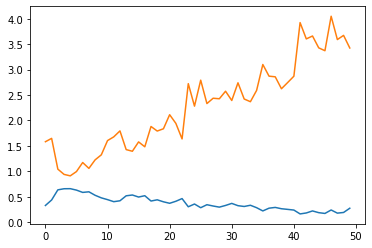

In [ ]:
plt.plot(ctraining_history['D_losses'])
plt.plot(ctraining_history['G_losses'])
plt.show()

# **TESTING ON THE PRETRAINED PIX2PIX MODEL**

In [ ]:
! git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git 
! ls
%cd /content/pytorch-CycleGAN-and-pix2pix
! pwd

! bash ./scripts/download_pix2pix_model.sh sat2map
# ! bash ./datasets/download_pix2pix_dataset.sh maps

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2337, done.
remote: Total 2337 (delta 0), reused 0 (delta 0), pack-reused 2337
Receiving objects: 100% (2337/2337), 8.09 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (1499/1499), done.
content  maps  myresults  pix2pix.gz  pytorch-CycleGAN-and-pix2pix  sample_data
/content/pytorch-CycleGAN-and-pix2pix
/content/pytorch-CycleGAN-and-pix2pix
Note: available models are edges2shoes, sat2map, map2sat, facades_label2photo, and day2night
Specified [sat2map]
for details.

--2021-02-15 15:58:27--  http://efrosgans.eecs.berkeley.edu/pix2pix/models-pytorch/sat2map.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217704720 (208M)
Saving to: ‘./checkpoints/sat2map_pretrained/latest_net_G.pth’

./checkpoints/sat2m 100%[=======

In [ ]:

! pip install -r requirements.txt --quiet

! python test.py --dataroot /content/maps/val/ --direction AtoB --model pix2pix --name sat2map_pretrained

     |████████████████████████████████| 686kB 6.4MB/s 
     |████████████████████████████████| 204kB 14.8MB/s 
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/maps/val/            	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  i

Here, the below cell will group the result belonging to the same satellite image into a dictionary. hm

In [ ]:
filenames = os.listdir("./results/sat2map_pretrained/test_latest/images")
print(len(filenames))

hm = {}
for file_ in filenames:
    word = file_.split("_")
    index = word[0]
    if index not in hm:
        hm[index]={}
    key = word[1]
    
    if key=="fake":
        
        hm[index]["fake_map"] = file_
        
    elif key=="real" and word[-1][0]=="A":
        
        hm[index]["satellite"]= file_
    else:
        
        hm[index]["real_map"] = file_

In [ ]:
import matplotlib.image as mpimg

# **PLOTTING THE RESULTS OF pix2pix MODEL**

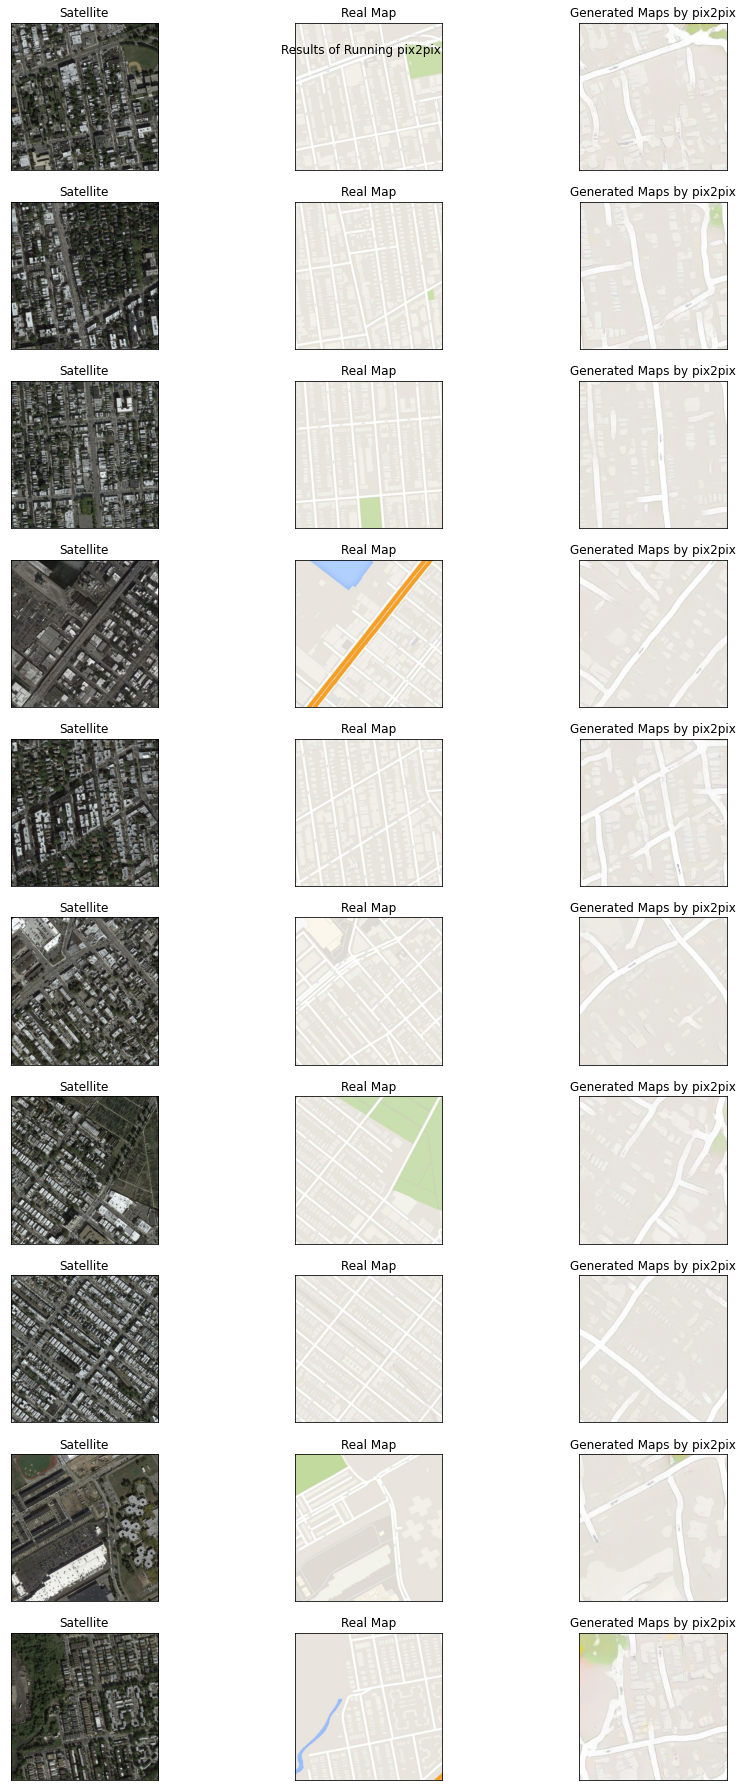

In [ ]:
fig,axes = plt.subplots(10,3,figsize=(12,25))
plt.suptitle("Results of Running pix2pix")
fig.tight_layout()


path  ="./results/sat2map_pretrained/test_latest/images/"
i = 0 
for key in test_files:
    axes[i][0].imshow(mpimg.imread(path+hm[key]["satellite"]))
    axes[i][0].set_title("Satellite");axes[i][0].set_xticks([]);axes[i][0].set_yticks([])
    axes[i][1].imshow(mpimg.imread(path+hm[key]["real_map"]))
    axes[i][1].set_title("Real Map");axes[i][1].set_xticks([]);axes[i][1].set_yticks([])
    axes[i][2].imshow(mpimg.imread(path+hm[key]["fake_map"]))
    axes[i][2].set_title("Generated Maps by pix2pix");axes[i][2].set_xticks([]);axes[i][2].set_yticks([])
    i+=1
    if i==10:
        break

plt.subplots_adjust(top=None,bottom=None,right=None,wspace=None, hspace=None)
plt.show()

In [ ]:
from skimage.metrics import structural_similarity 
import matplotlib.image as mpimg

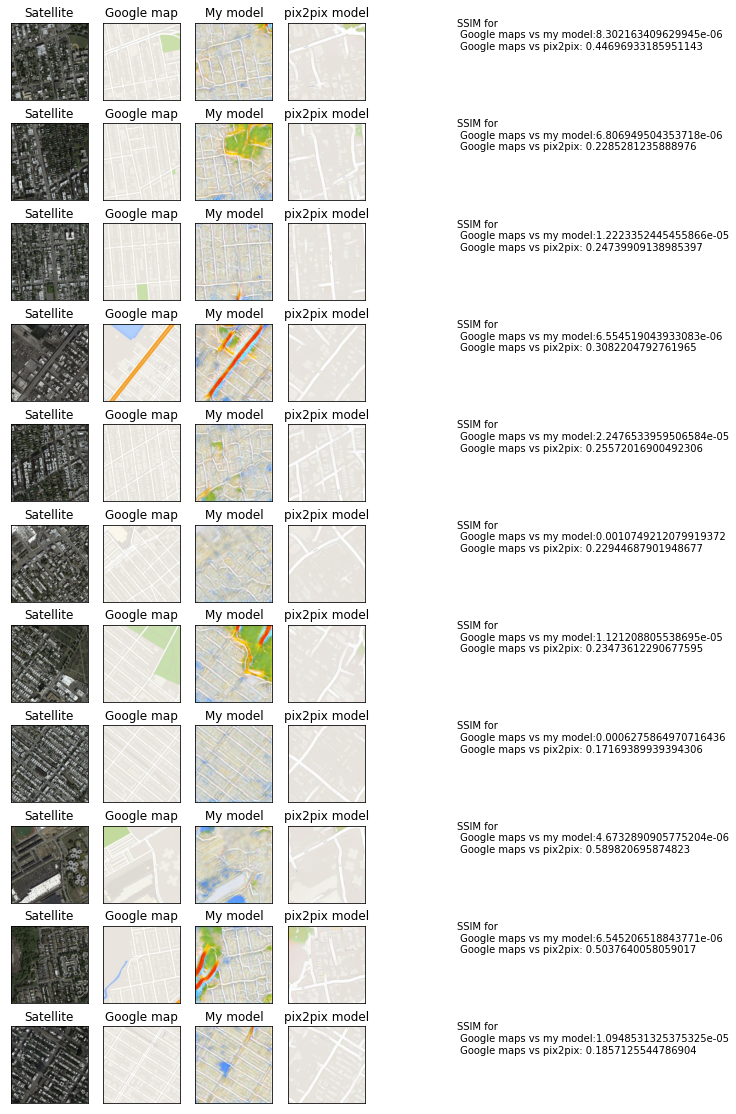

In [ ]:
fig,axes = plt.subplots(11,5,figsize=(8,20))


for i,key in enumerate(test_files):
    
    mymodel_img = mpimg.imread(f"/content/myresults/{key}.jpg")
    pretrained_img = mpimg.imread(path+hm[key]["fake_map"])
    satellite = mpimg.imread(path+hm[key]["satellite"])
    google_map = mpimg.imread(path+hm[key]["real_map"])

    ssim_gm_mymodel = structural_similarity(google_map, mymodel_img,data_range=google_map.max() - mymodel_img.min(),multichannel=True)
    ssim_gm_pix2pix = structural_similarity(google_map,pretrained_img, data_range=google_map.max() - pretrained_img.min(),multichannel=True)
    
    axes[i][0].imshow(satellite)
    axes[i][0].set_title("Satellite")
    axes[i][0].set_xticks([]);axes[i][0].set_yticks([]);

    axes[i][1].imshow(google_map)
    axes[i][1].set_title("Google map")
    axes[i][1].set_xticks([]);axes[i][1].set_yticks([]);


    axes[i][2].imshow(mymodel_img)
    axes[i][2].set_title("My model")
    axes[i][2].set_xticks([]);axes[i][2].set_yticks([]);

    axes[i][3].imshow(pretrained_img)
    axes[i][3].set_title("pix2pix model")
    axes[i][3].set_xticks([]);axes[i][3].set_yticks([]);

    axes[i][4].text(1,0.5,'SSIM for \n Google maps vs my model:{}\n Google maps vs pix2pix: {}\n'.format(ssim_gm_mymodel,ssim_gm_pix2pix))
    axes[i][4].set_xticks([]);axes[i][4].set_yticks([]);
    axes[i,4].axis("off")

    if i==10:
        break
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()